In [38]:
import pickle
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marioreyes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [39]:
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=300, window=10, min_count=2, epochs=20):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.epochs = epochs
        self.model = None
        
    def fit(self, X, y=None):
        tokenized_texts = []
        for text in X:
            words = word_tokenize(text.lower())
            words = [word for word in words if len(word) > 1]
            tokenized_texts.append(words)
        

        self.model = Word2Vec(sentences=tokenized_texts,
                            vector_size=self.vector_size,
                            window=self.window,
                            min_count=self.min_count,
                            workers=4,
                            epochs=self.epochs,
                            sg=1)  # Skip-gram
        return self
    
    def transform(self, X):
        if self.model is None:
            raise ValueError("Model not fitted yet!")
        
        features = np.zeros((len(X), self.vector_size))
        
        for i, text in enumerate(X):
            word_vectors = []
            words = word_tokenize(text.lower())
            words = [word for word in words if len(word) > 1]
            
            for word in words:
                if word in self.model.wv:
                    word_vectors.append(self.model.wv[word])
            
            if word_vectors:
                features[i] = np.mean(word_vectors, axis=0)
                features[i] = features[i] / np.linalg.norm(features[i])
                
        return features

class VocabularyRichnessTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        features = np.zeros((len(X), 4))
        
        for i, text in enumerate(X):
            words = word_tokenize(text.lower())
            unique_words = set(words)
            
            if words:
                # Type-token ratio
                features[i, 0] = len(unique_words) / len(words)
                
                # Hapax legomena ratio (words appearing only once)
                word_counts = Counter(words)
                hapax = sum(1 for word, count in word_counts.items() if count == 1)
                features[i, 1] = hapax / len(words)
                
                # Average word length
                features[i, 2] = sum(len(word) for word in words) / len(words)
                
                # Vocabulary size
                features[i, 3] = len(unique_words)
        
        return features

class FunctionWordTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.function_words = [
            'the', 'of', 'and', 'a', 'to', 'in', 'is', 'you', 'that', 'it',
            'he', 'was', 'for', 'on', 'are', 'as', 'with', 'his', 'they',
            'I', 'at', 'be', 'this', 'have', 'from', 'or', 'one', 'had',
            'by', 'but', 'not', 'what', 'all', 'were', 'we', 'when', 'your',
            'can', 'said', 'there', 'use', 'an', 'each', 'which', 'she', 'do',
            'how', 'their', 'if', 'will', 'up', 'other', 'about', 'out', 'many'
        ]
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        features = np.zeros((len(X), len(self.function_words)))
        
        for i, text in enumerate(X):
            words = word_tokenize(text.lower())
            total_words = len(words) if words else 1
            
            for j, func_word in enumerate(self.function_words):
                count = sum(1 for word in words if word == func_word)
                features[i, j] = count / total_words
                
        return features

In [40]:
feature_pipeline = Pipeline([
    ('features', FeatureUnion([
        ('word2vec', Word2VecTransformer(vector_size=500, window=15, min_count=2, epochs=20)),
        ('vocab_richness', VocabularyRichnessTransformer()),
        ('function_words', FunctionWordTransformer())
    ], transformer_weights={
        'word2vec': 0.8,
        'vocab_richness': 0.1,
        'function_words': 0.1
    }))
])

In [41]:
data = pd.read_csv('data/train.csv', sep=',')
print(f'Total de datos = {data.size}')

print(f'Duplicados: {data.duplicated().sum()}')
data = data.drop_duplicates()
print(f'Duplicados: {data.duplicated().sum()}')

X_ = data['text']
y_ = data['label']


X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

Total de datos = 181452
Duplicados: 3
Duplicados: 0


In [42]:
print("Extracting features...")
X_train_features = feature_pipeline.fit_transform(X_train, y_train)
X_test_features = feature_pipeline.transform(X_test)


print("\nClass distribution before oversampling:")
print(Counter(y_train))

print("\nApplying SMOTE oversampling...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_features, y_train)


print("\nClass distribution after oversampling:")
print(Counter(y_train_balanced))

Extracting features...


/Users/marioreyes/Documents/p_repositories/uniandes/FPLN_team3/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Class distribution before oversampling:
Counter({0: 20899, 1: 12978, 2: 7746, 3: 3521, 4: 3240})

Applying SMOTE oversampling...

Class distribution after oversampling:
Counter({0: 20899, 1: 20899, 2: 20899, 4: 20899, 3: 20899})


In [43]:
print("\nTraining the classifier...")
classifier = LogisticRegression(
    C=1.0,
    max_iter=2000,
    class_weight='balanced',
    solver='lbfgs',
    n_jobs=-1
)
classifier.fit(X_train_balanced, y_train_balanced)

# Make predictions
print("Making predictions...")
y_pred = classifier.predict(X_test_features)


Training the classifier...
Making predictions...



Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      5197
           1       0.88      0.88      0.88      3285
           2       0.78      0.88      0.83      1839
           3       0.73      0.84      0.78       926
           4       0.82      0.93      0.87       850

    accuracy                           0.87     12097
   macro avg       0.83      0.88      0.85     12097
weighted avg       0.88      0.87      0.87     12097



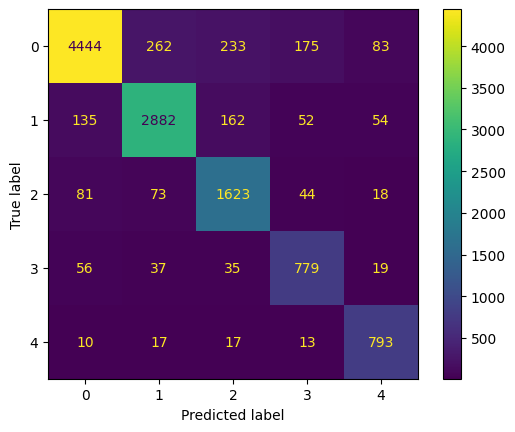

In [44]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred)) 

cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()

In [45]:
test_data = pd.read_csv('data/test.csv', sep=',')
print(f'Total de datos = {test_data.size}')

X_t = test_data['text']
X_t_features = feature_pipeline.fit_transform(X_t)

test_data['label'] = classifier.predict(X_t_features)
test_data[['ID', 'label']].to_csv('submission.csv', index=False)

Total de datos = 10230


In [46]:
# Guardar el modelo entrenado
with open("model_word2vec.pkl", "wb") as f:
    pickle.dump(classifier, f)

print("Saved: model_word2vec.pkl")

Saved: model_word2vec.pkl
